### Import Required Libraries

In [43]:
import numpy as np
from scipy.integrate import odeint
from scipy.signal import butter, filtfilt, find_peaks
from scipy.stats import gaussian_kde,ecdf
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline,LinearNDInterpolator
from scipy.optimize import fsolve
import time
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

#### Polynomial Fit

In [44]:
def quadFit(x,a1,a2,a3):
    return a1*x**2+a2*x+a3

### Viscous_parameters_solver Function

In [45]:
def viscous_parameters_solver(t, theta,mdisk,mobject):
    l = 0.6505
    r = 0.36115625
    g = 9.7949
    mnet = mdisk+mobject #FIRST NUMBER IS DISK AND SENSOR, NOT INCLUDING TRANSMITTER
    noise_param = 0.04

     # Trim NaN values from t and theta
    validIndicies = ~np.isnan(theta)
    t = t[validIndicies]
    theta = theta[validIndicies]
    
    # Filter the data
    b, a = butter(4, 0.05, 'low')
    filtered_theta = filtfilt(b, a, theta)
    peak_filtering_param = 3 #remember to adjust as to remove outliers associated with signal noise

    

    # Use find_peaks with adjusted parameters to identify peaks
    peaks, _ = find_peaks(filtered_theta, prominence=np.deg2rad(noise_param*peak_filtering_param))  # adjust prominence if needed

    # Check if peaks are found
    if len(peaks) == 0:
        print("No peaks were found.")
        return [0, 0, 0, 0]

    # Calculate the periods between peaks
    periods = np.diff(t[peaks])
    # plt.figure()
    # plt.plot(t,theta,'kx',ms=1)
    # plt.plot(t,filtered_theta,'r-')
    # plt.xlim((0,15))
    # plt.show()
    # plt.figure()
    # plt.plot(periods)
    # plt.show()
    # Calculate median filtered period
    T_d = np.median(periods)
    # print(f"T_d = {T_d}", end='\n')
    omega_d = (2 * np.pi) / T_d
    # print(f"Calculated wd = {omega_d}", end='\n')

    # Calculate the damping ratio
    amplitude_ratios = filtered_theta[peaks][1:] / filtered_theta[peaks][:-1]
    damping_ratios = -1*np.log(amplitude_ratios)
    # print(f"Calculated dr = {np.median(damping_ratios)}",end='\n')
    zeta = np.median(damping_ratios) / ( np.sqrt( (4 * np.pi ** 2) + (np.median(damping_ratios) ** 2) ) )
    # print(f"Calculated zeta = {zeta}",end='\n')

    # Calculate natural frequency and inertia
    omega_n = omega_d / np.sqrt(1 - zeta ** 2)
    Inet_pure = (mnet * g * r ** 2) / (l * omega_n ** 2)
    c_pure = zeta * 2 * np.sqrt(Inet_pure * ((mnet * g * r ** 2) / l))

    return [Inet_pure, (mnet * g * r ** 2) / l, c_pure, 0]


#### Calculating Disk Inertia, Known Inertia Values

In [46]:
# # Importing Disk Data
folder_path = '/home/coder/workspace/Finnamore/GODSAMONGUS'
disk_path = '/home/coder/workspace/Finnamore/GODSAMONGUS'
numTests = 30
df_disk_data = {}
disk_inertia_data = np.zeros(numTests)
disk_period_data = np.zeros(numTests)

# Importing and Calculating Disk Inertial Data
for i in range(numTests):
    # File Path Creation
    file_name = 'I_D_4.4.24_{:02}.csv'.format(i)
    file_path = os.path.join(disk_path,file_name)

    #Reading in Data
    df = pd.read_csv(file_path,usecols=[0,1])
    df_disk_data[i] = df.values

    #Solving for Disk Inertia
    
    disk_inertia_data[i] = viscous_parameters_solver(df_disk_data[i][:,0],df_disk_data[i][:,1],5.024,0)[0]

#Setting up Dicitonary of Known Inertial Values
disk_inertia = np.median(disk_inertia_data)
disk_period = np.median(disk_period_data)
I_names = ['Bigd','Smalld']
print(disk_inertia)
# Calculating and Storing Known Inertial Values
m_single_weight = 0.4465



0.4766684983469293


### Import Data


In [47]:
raw_data = {}
inertia_data = {}
period_data = {}
# Define the pattern or names of your CSV files
for name in I_names:
    raw_data[name] = {}
    inertia_data[name] = np.zeros(numTests)
    period_data[name] = np.zeros(numTests)
    for i in range(numTests):
        if(name=='Bigd'):
            file_name = ('I_2C_4.4.24_{}_{:02}.csv'.format('1',i))
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path, usecols=[0, 1])
            raw_data[name][i] = df.values
            inertia_data[name][i] = viscous_parameters_solver(raw_data[name][i][:,0],raw_data[name][i][:,1],5.024,2*m_single_weight)[0] - disk_inertia
        elif(name=='Smalld'):
            file_name = ('I_2C_{}_{:02}.csv'.format('1',i))
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path, usecols=[0, 1])
            raw_data[name][i] = df.values
            inertia_data[name][i] = viscous_parameters_solver(raw_data[name][i][:,0],raw_data[name][i][:,1],2.974,2*m_single_weight)[0] - 0.2


### Plot/Print Results

Big D Error: 0.028960911031251254
Small D Error: 0.004099628928789318
[0.02925669 0.02771445 0.02925676 0.02887092 0.03002916 0.02925691
 0.02887136 0.02925686 0.029256   0.0300284  0.02848493 0.02848514
 0.02964251 0.02848539 0.02925732 0.02925675 0.02887059 0.02925683
 0.02848486 0.02925663 0.02925665 0.02848445 0.02848527 0.02925628
 0.0284848  0.02848463 0.02925653 0.02848448 0.02925648 0.0280993 ]
[0.00409278 0.00448935 0.00409284 0.00409294 0.00448941 0.00330106
 0.00448932 0.0036967  0.00409296 0.00409284 0.00369677 0.00369668
 0.00448937 0.00409289 0.00448937 0.00369686 0.00369677 0.00429116
 0.00369669 0.00448927 0.00409295 0.00429118 0.00409272 0.00369664
 0.0040929  0.00409296 0.00468781 0.00448947 0.00448943 0.0036968 ]


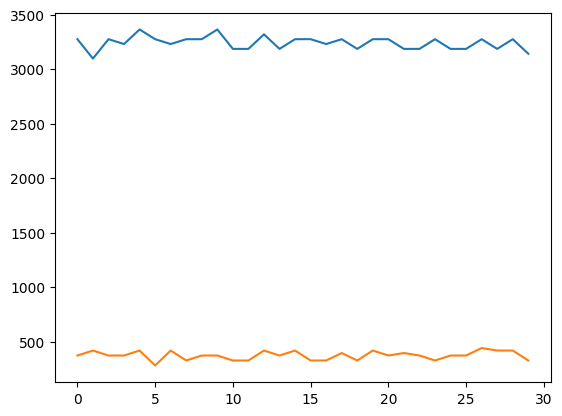

In [49]:
actualInertia = 2*(0.4465*(0.0254**2)+(0.5*0.4465*((0.051/2)**2)))
errorBig = 100*((inertia_data['Bigd']-actualInertia)/(actualInertia))
errorSmall = 100*((inertia_data['Smalld']-actualInertia)/(actualInertia))
print('Big D Error: {}'.format(np.mean(inertia_data['Bigd'])))
print('Small D Error: {}'.format(np.mean(inertia_data['Smalld'])))
plt.plot(errorBig)
plt.plot(errorSmall)
print(inertia_data['Bigd'])
print(inertia_data['Smalld'])

# kde_big = gaussian_kde(inertia_data['Bigd'])
# kde_small = gaussian_kde(inertia_data['Smalld'])
# xi_big = np.linspace(np.min(inertia_data['Bigd']),np.max(inertia_data['Bigd']),1000)
# xi_big = np.linspace(np.min(inertia_data['Smalld']),np.max(inertia_data['Smalld']),1000)
# plt.figure(figsize=(8,6))
# print(xi_big)